In [1]:
import sys
sys.path.append('/home/s94zalek_hpc/shape_matching')

import trimesh.visual
import yaml
import torch

sys.path.append('/home/s94zalek_hpc/shape_matching/pyFM_fork')

import pyFM

import numpy as np

from pyFM.mesh import TriMesh
from pyFM.functional import FunctionalMapping

import trimesh

scene = trimesh.Scene()

def plot_mesh(myMesh,cmap=None):
    scene.geometry.clear()
    
    scene.add_geometry(trimesh.Trimesh(vertices=myMesh.vertlist,faces=myMesh.facelist, vertex_colors=cmap))
    
    # mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    # d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    # mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)
    
    scene.geometry.clear()
    
    mesh1 = trimesh.Trimesh(vertices=myMesh1.vertlist,faces=myMesh1.facelist, vertex_colors=cmap1)
    mesh2 = trimesh.Trimesh(vertices=myMesh2.vertlist + np.array([1, 0, 0]),faces=myMesh2.facelist, vertex_colors=cmap2)
    
    scene.add_geometry(mesh1)
    scene.add_geometry(mesh2)
    

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    
    # cmap = trimesh.visual.color.interpolate(vertices, 'jet')
    return cmap

In [2]:
import my_code.diffusion_training.data_loading as data_loading

test_dataset = data_loading.get_val_dataset(
    'FAUST_r', 'train', 200
    )[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:13<00:00,  5.95it/s]


# Initialization with descriptors

In [3]:
data_10 = test_dataset[15]

In [4]:
from pyFM.mesh import TriMesh

mesh1 = TriMesh(
    data_10['first']['verts'],
    data_10['first']['faces'],
    center=True, area_normalize=True
    ).process(k=150, intrinsic=True)

mesh2 = TriMesh(
    data_10['second']['verts'],
    data_10['second']['faces'],
    center=True, area_normalize=True
    ).process(k=150, intrinsic=True)

In [5]:
from pyFM.signatures.WKS_functions import mesh_WKS
from pyFM.signatures.HKS_functions import mesh_HKS
from pyFM.spectral.nn_utils import knn_query

wks_descr1 = mesh_WKS(mesh1, num_E=100, k=100)
wks_descr2 = mesh_WKS(mesh2, num_E=100, k=100)

hks_descr1 = mesh_HKS(mesh1, num_T=100, k=100)
hks_descr2 = mesh_HKS(mesh2, num_T=100, k=100)

# WKS initialisation
p2p_21_wks = knn_query(wks_descr1, wks_descr2, k=1) # (n2,) initialisation with 1-NN


In [ ]:
cmap1 = visu(mesh1.vertlist)
cmap2_wks = cmap1[p2p_21_wks]
# cmap2_nn = cmap1[p2p_21_nn]

double_plot(mesh1,mesh2,cmap1,cmap2_wks)
scene.show()

In [8]:
def diff_to_vertex(descr1, descr2, vertex_index):

    vertex_descr = descr1[vertex_index]

    # diff = np.linalg.norm(wks_descr2 - vertex_0_descr, axis=1)
    
    diff = np.linalg.norm(descr2 - vertex_descr, axis=1)

    print('diff',diff)
    # print indices of the closest vertices
    closest_vertex_indices = np.argsort(diff)[:10]
    print('closest_vertex_indices',closest_vertex_indices)
    print('diff[closest_vertex_indices]',diff[closest_vertex_indices])
    
print('WKS')
diff_to_vertex(wks_descr1, wks_descr2, 0)

print('HKS')
diff_to_vertex(hks_descr1, hks_descr2, 0)

WKS
diff [1.82467682 1.46131502 1.3782764  ... 3.32459183 3.23180222 3.22656845]
closest_vertex_indices [3518 3519 3671 3648 3678 3672  377  155 3700  273]
diff[closest_vertex_indices] [0.35793668 0.38222223 0.386808   0.41702863 0.42942281 0.44297318
 0.45220596 0.51583517 0.52666106 0.56373346]
HKS
diff [1.30129234 1.19035407 1.15060202 ... 0.83860725 0.81013451 0.81486519]
closest_vertex_indices [3530 3531 3787   40 3556   95 3537   43 3913 3912]
diff[closest_vertex_indices] [0.47963173 0.48114667 0.4812772  0.48161651 0.48291483 0.48309476
 0.4832002  0.48341454 0.48342759 0.48363679]


In [9]:
closest_vertices_list = []

for i in range(6890):
    vertex_index = i
    
    
    vertex_descr = wks_descr1[vertex_index]

    diff = np.linalg.norm(wks_descr2 - vertex_descr, axis=1)

    
    # print indices of the closest vertices
    closest_vertex_indices = np.argsort(diff)[:10]
    
    closest_vertices_list.append({
        'vertex_1_index': vertex_index,
        'closest_vertex_2': closest_vertex_indices[0],
        'difference': diff[closest_vertex_indices[0]]
    })
    
# print vertices with lowest difference
closest_vertices_list = sorted(closest_vertices_list, key=lambda x: x['difference'])
print('closest_vertices_list',closest_vertices_list[:10])

closest_vertices_list [{'vertex_1_index': 3191, 'closest_vertex_2': 3180, 'difference': 0.13715434103539229}, {'vertex_1_index': 2997, 'closest_vertex_2': 4214, 'difference': 0.14712766731611449}, {'vertex_1_index': 6721, 'closest_vertex_2': 6596, 'difference': 0.15288144509978982}, {'vertex_1_index': 3321, 'closest_vertex_2': 6579, 'difference': 0.1550318225547286}, {'vertex_1_index': 2931, 'closest_vertex_2': 726, 'difference': 0.15545014677716407}, {'vertex_1_index': 6456, 'closest_vertex_2': 4214, 'difference': 0.1564723164912712}, {'vertex_1_index': 2998, 'closest_vertex_2': 4382, 'difference': 0.1710342269620652}, {'vertex_1_index': 3320, 'closest_vertex_2': 6580, 'difference': 0.17301199695168828}, {'vertex_1_index': 6409, 'closest_vertex_2': 4697, 'difference': 0.18107167857820905}, {'vertex_1_index': 4216, 'closest_vertex_2': 4696, 'difference': 0.18596262096188562}]


In [ ]:
vertex_index = 3

# highlight the closest vertices on both meshes
cmap1 = visu(mesh1.vertlist)
cmap1 = np.ones_like(cmap1)
cmap1[closest_vertices_list[vertex_index]['vertex_1_index']] = np.array([0,0,0])

cmap2_wks = np.ones_like(cmap1)
cmap2_wks[closest_vertices_list[vertex_index]['closest_vertex_2']] = np.array([0,0,0])



double_plot(mesh1,mesh2,cmap1,cmap2_wks)
scene.show()

In [35]:
corr_1 = [closest_vertices_list[i]['vertex_1_index'] for i in range(300)]
corr_2 = [closest_vertices_list[i]['closest_vertex_2'] for i in range(300)]

In [38]:
descr_1 = torch.tensor(wks_descr1)[corr_1].float()
descr_2 = torch.tensor(wks_descr2)[corr_2].float()



Cxy_lstsq = torch.linalg.lstsq(
    descr_1.T @ data_10['first']['evecs_trans'].T[corr_1][:, :10],
    descr_2.T @ data_10['second']['evecs_trans'].T[corr_2][:, :10]
).solution.T

# Cxy_lstsq = torch.linalg.lstsq(evecs_1, evecs_2).solution
Cxy_lstsq.shape

# Cxy_lstsq.shape

torch.Size([10, 10])

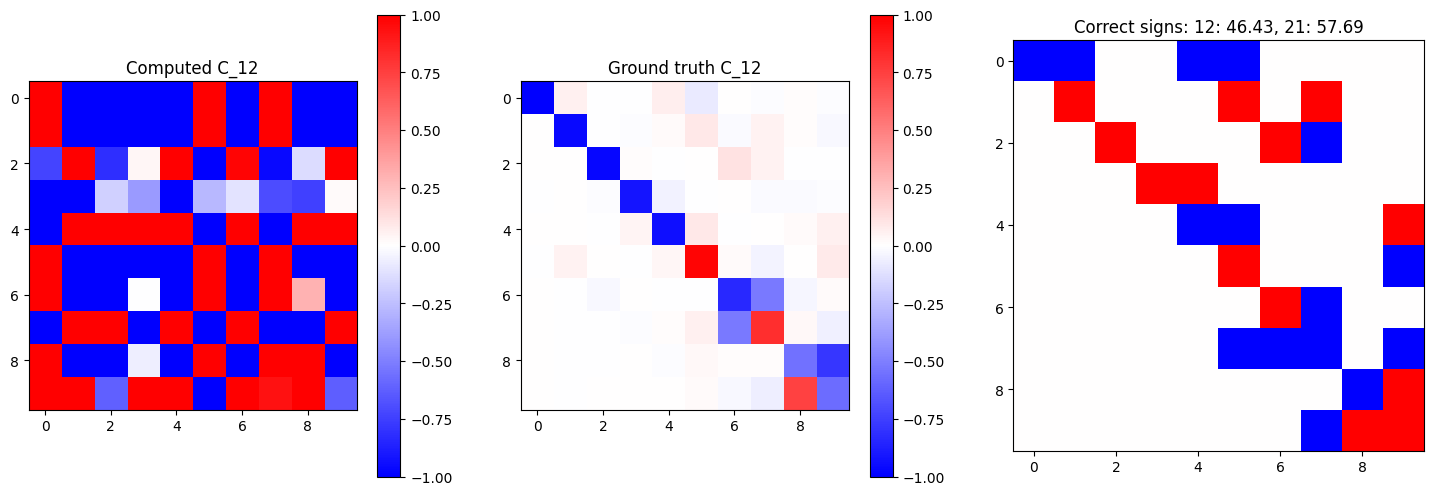

In [40]:
import matplotlib.pyplot as plt

C_12_gt = data_10['second']['C_gt_xy'][0][:10, :10]
C_21_gt = data_10['second']['C_gt_yx'][0][:10, :10]



fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax_0 = ax[0].imshow(Cxy_lstsq[:16, :16], cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(ax_0, ax=ax[0])
ax[0].set_title('Computed C_12')

ax_1 = ax[1].imshow(C_12_gt, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(ax_1, ax=ax[1])
ax[1].set_title('Ground truth C_12')


sign_diff = np.sign(Cxy_lstsq.numpy()) * np.sign(C_12_gt.numpy()) * (C_12_gt.abs() > 0.05).int().numpy()
correct_signs = np.sum(sign_diff == 1) / (np.sum(sign_diff == 1) + np.sum(sign_diff == -1))

sign_diff_21 = np.sign(Cxy_lstsq.numpy().T) * np.sign(C_21_gt.numpy()) * (C_21_gt.abs() > 0.05).int().numpy()
correct_signs_21 = np.sum(sign_diff_21 == 1) / (np.sum(sign_diff_21 == 1) + np.sum(sign_diff_21 == -1))

ax[2].imshow(sign_diff, cmap='bwr', vmin=-1, vmax=1)
ax[2].set_title(f'Correct signs: 12: {correct_signs*100:.2f}, 21: {correct_signs_21*100:.2f}')

plt.show()


# Functional Mapping

In [53]:
process_params = {
    'n_ev': (200,200),  # Number of eigenvalues on source and Target
    'subsample_step': 1,  # In order not to use too many descriptors
    'descr_type': 'WKS',  # WKS or HKS
}

model = FunctionalMapping(mesh1,mesh2)
model.preprocess(**process_params,verbose=True)


Computing Laplacian spectrum
Computing 200 eigenvectors
	Done in 0.78 s
Computing 200 eigenvectors
	Done in 0.79 s

Computing descriptors
	Normalizing descriptors

	100 out of 100 possible descriptors kept


In [54]:
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 0
}
model.fit(**fit_params, verbose=True)

Computing commutativity operators
	Scaling LBO commutativity weight by 2.8e-11

Optimization :
	200 Ev on source - 200 Ev on Target
	Using 100 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-02
		Orientation preservation :0.0e+00

	Task : CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH, funcall : 243, nit : 238, warnflag : 0
	Done in 48.58 seconds


In [ ]:
p2p_21 = model.get_p2p(n_jobs=1)
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot(mesh1,mesh2,cmap1,cmap2)

scene.show()

In [23]:
C_12 = model.FM
C_12_gt = data_10['second']['C_gt_xy'][0][:C_12.shape[0], :C_12.shape[1]]
C_21_gt = data_10['second']['C_gt_yx'][0][:C_12.shape[1], :C_12.shape[0]]

NameError: name 'model' is not defined

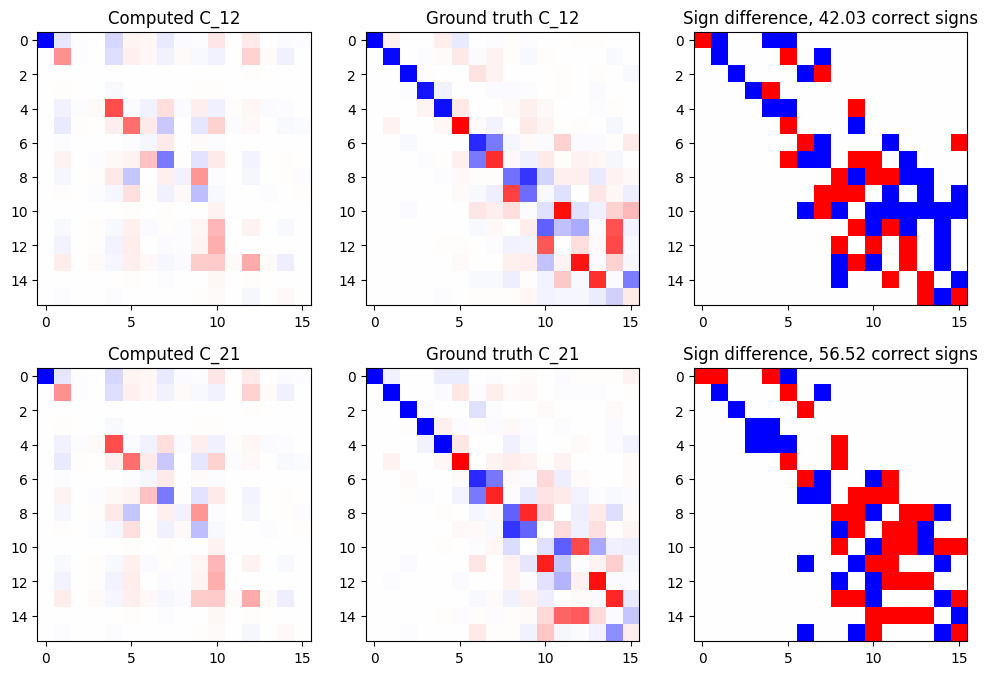

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(12, 8))


show_size = 16

C_12 = C_12[:show_size, :show_size]
C_12_gt = C_12_gt[:show_size, :show_size]
C_21_gt = C_21_gt[:show_size, :show_size]


ax[0][0].imshow(C_12, cmap='bwr', vmin=-1, vmax=1)
ax[0][0].set_title('Computed C_12')

ax[0][1].imshow(C_12_gt, cmap='bwr', vmin=-1, vmax=1)
ax[0][1].set_title('Ground truth C_12')

sign_diff = np.sign(C_12) * np.sign(C_12_gt.numpy()) * (C_12_gt.abs() > 0.05).int().numpy()
correct_signs = np.sum(sign_diff == 1) / (np.sum(sign_diff == 1) + np.sum(sign_diff == -1))


ax[0][2].imshow(sign_diff, cmap='bwr', vmin=-1, vmax=1)
ax[0][2].set_title(f'Sign difference, {correct_signs * 100:.2f} correct signs')


ax[1][0].imshow(C_12, cmap='bwr', vmin=-1, vmax=1)
ax[1][0].set_title('Computed C_21')

ax[1][1].imshow(C_21_gt, cmap='bwr', vmin=-1, vmax=1)
ax[1][1].set_title('Ground truth C_21')

sign_diff_2 = np.sign(C_12) * np.sign(C_21_gt.numpy()) * (C_21_gt.abs() > 0.05).int().numpy()
correct_signs_2 = np.sum(sign_diff_2 == 1) / (np.sum(sign_diff_2 == 1) + np.sum(sign_diff_2 == -1))

ax[1][2].imshow(sign_diff_2, cmap='bwr', vmin=-1, vmax=1)
ax[1][2].set_title(f'Sign difference, {correct_signs_2 * 100:.2f} correct signs')



plt.show()

# Least squares on first eigenfunctions directly

In [100]:
evecs_1 = data_10['first']['evecs']
evecs_2 = data_10['second']['evecs']

n_eig = 16

evecs_1 = evecs_1[:, :n_eig]
evecs_2 = evecs_2[:, :n_eig]

Cxy_lstsq = torch.linalg.lstsq(
    torch.sign(evecs_1.T) @ data_10['first']['evecs_trans'][:n_eig, :].T,
    torch.sign(evecs_2.T) @ data_10['second']['evecs_trans'][:n_eig, :].T
).solution.T

# Cxy_lstsq = torch.linalg.lstsq(evecs_1, evecs_2).solution
Cxy_lstsq.shape

# Cxy_lstsq.shape

torch.Size([16, 16])

In [101]:
evecs_1.T @ data_10['first']['evecs_trans'].T

tensor([[ 1.0000e+00,  2.9802e-08,  7.4506e-08,  ..., -1.6944e-09,
          1.4241e-08,  3.8635e-09],
        [ 2.2352e-08,  1.0000e+00,  1.0431e-07,  ..., -1.6298e-09,
          1.3970e-09, -6.9849e-10],
        [ 8.9407e-08,  1.0431e-07,  1.0000e+00,  ..., -7.1299e-09,
         -2.2374e-09, -1.6718e-09],
        ...,
        [ 5.3551e-08, -1.1642e-08, -1.8626e-09,  ..., -1.6997e-08,
         -6.9849e-10, -4.6566e-10],
        [-1.5367e-08, -1.3970e-09,  8.3819e-09,  ...,  7.4273e-09,
          2.0903e-08,  2.7783e-09],
        [ 3.9116e-08,  3.9116e-08,  2.6077e-08,  ...,  3.7253e-09,
         -4.6566e-10, -1.8626e-09]])

Text(0.5, 1.0, 'Ground truth C_12')

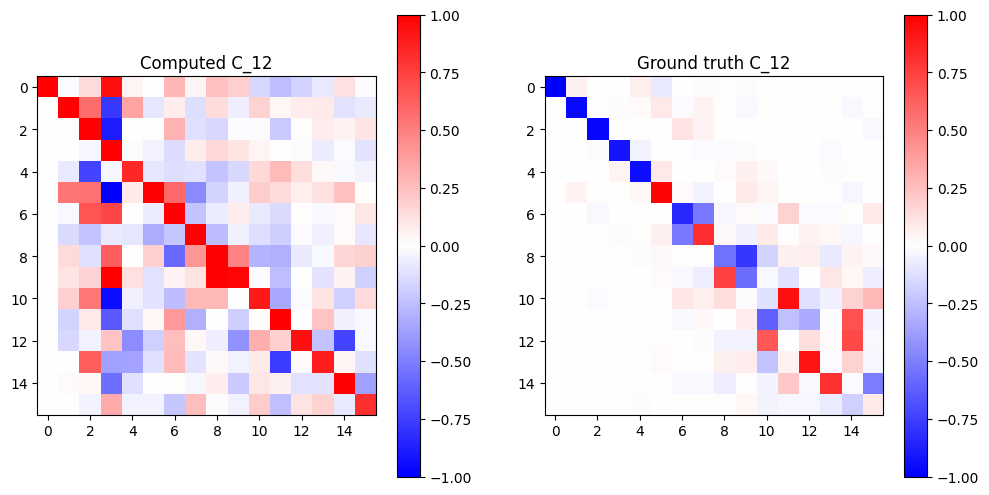

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax_0 = ax[0].imshow(Cxy_lstsq[:16, :16], cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(ax_0, ax=ax[0])
ax[0].set_title('Computed C_12')

ax_1 = ax[1].imshow(C_12_gt, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(ax_1, ax=ax[1])
ax[1].set_title('Ground truth C_12')


# Zoomout

In [5]:
from pyFM.refine.zoomout import zoomout_refine

In [6]:
Cxy_full = data_10['second']['C_gt_xy'][0]

init_dim = 16
out_dim = 64

Cxy_init = Cxy_full[:init_dim, :init_dim]
Cxy_gt = Cxy_full[:out_dim, :out_dim]

Cxy_refined = zoomout_refine(
    FM_12=Cxy_init.numpy(), 
    evects1=data_10['first']['evecs'].numpy(), 
    evects2=data_10['second']['evecs'].numpy(),
    nit=out_dim - init_dim, step=1,
    verbose=True
)

  0%|          | 0/48 [00:00<?, ?it/s]

Correct signs: 97.00%, Incorrect signs: 3.00%


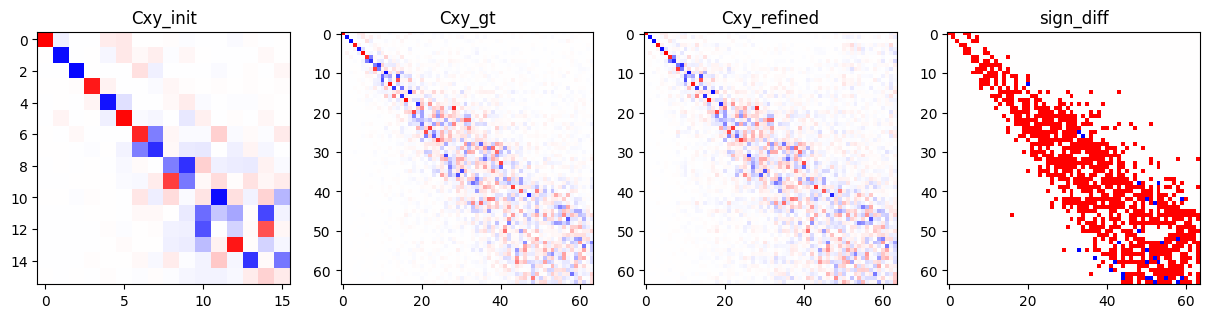

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

ax_0 = ax[0].imshow(Cxy_init, cmap='bwr', vmin=-1, vmax=1)
ax[0].set_title('Cxy_init')
# plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(Cxy_gt, cmap='bwr', vmin=-1, vmax=1)
ax[1].set_title('Cxy_gt')
# plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(Cxy_refined, cmap='bwr', vmin=-1, vmax=1)
ax[2].set_title('Cxy_refined')
# plt.colorbar(ax_2, ax=ax[2])

sign_diff = np.sign(Cxy_gt) * np.sign(Cxy_refined)
sign_diff = sign_diff * (np.abs(Cxy_gt) > 0.05)

ax_3 = ax[3].imshow(sign_diff, cmap='bwr')
ax[3].set_title('sign_diff')
# plt.colorbar(ax_3, ax=ax[3])


print(f'Correct signs: {100 * torch.sum(sign_diff == 1) / torch.sum(sign_diff != 0):.2f}%, '
      f'Incorrect signs: {100 * torch.sum(sign_diff == -1) / torch.sum(sign_diff != 0):.2f}%')

plt.show()


In [64]:
torch.sum(torch.abs(torch.tensor(Cxy_refined) - Cxy_gt))

tensor(253.8035)